# Example: Let's Decompose a Synthetic Data Cloud
In this example, we generate a synthetic dataset that simulates a cloud of points in a two-dimensional space. We'll then estimate the covariance matrix from the dataset, and use power iteration to compute the dominant eigenvalue and eigenvector of the covariance matrix.

> __Learning Objectives:__
> 
> By the end of this example, you should be able to:
> 
> * __Compute empirical covariance matrices from data:__ Calculate sample covariance matrices using centered data and verify results against standard implementations
> * __Apply power iteration to find dominant eigenpairs:__ Use the power iteration method to estimate the largest eigenvalue and associated eigenvector of a matrix
> * __Interpret eigendecomposition in data analysis:__ Explain how dominant eigenvectors represent directions of maximum variance in multidimensional datasets


Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Data
Let's generate a synthetic dataset that simulates a cloud of points in a two-dimensional space. We'll create points that are normally distributed around the origin with some added noise. 

> __Synthetic Data Model__
> 
> We generate points from a bivariate normal distribution with mean vector $\mathbf{\mu} \in \mathbb{R}^{2}$ and covariance matrix $\mathbf{\Sigma} \in \mathbb{R}^{2 \times 2}$. The correlation parameter $\rho \in [-1, 1]$ controls the linear relationship between the two dimensions. When $\rho = 0$, the dimensions are uncorrelated; when $\rho < 0$, they are negatively correlated; and when $\rho > 0$, they are positively correlated. The covariance matrix structure $\mathbf{\Sigma} = [1.0\, \rho; \rho\, 1.0]$ ensures unit variance in each dimension while introducing the specified correlation.

We'll save the data in the `X::Array{Float64,2}` variable, where each row represents a data point in 2D space.

In [2]:
X = let

    # initialize -
    number_of_points = 10000; # TODO: number of data points to generate, update as needed

    # specify distribution parameters
    μ = [0.1, 2.0]; # mean of the distribution
    ρ = -0.5; # create some correlation between dimensions
    Σ = [1.0 ρ; ρ 1.0]; # TODO: covariance matrix, update as needed
    d = MvNormal(μ, Σ); # define the multivariate normal distribution

    # generate synthetic data
    data = rand(d, number_of_points) |> transpose |> Matrix; # generate points and transpose to get points as rows
end

10000×2 Matrix{Float64}:
  0.499183   2.5549
 -1.4892     2.51504
 -0.359036   2.04516
 -0.71976    3.63734
 -1.65632    3.03127
  0.243408   1.36812
  1.31085    0.52534
 -1.40391    3.30202
  0.478755   1.55518
  1.01627    1.84159
  ⋮          
  0.133675   2.03969
  0.0218516  1.41095
  0.53826    0.295399
  0.435666   0.505752
 -1.17815    2.57747
 -1.36114    2.81813
  0.93335    2.48498
  0.23287    1.2285
 -1.42745    2.84378

___

## Task 1: Compute the Empirical Covariance Matrix
In this task, let's compute the empirical covariance matrix $\hat{\mathbf{\Sigma}}$ for our dataset $\mathcal{D}$ using code that we write ourselves (we'll never do this in practice, but it's a good exercise), and then we'll compare it to the built-in function. The empirical covariance matrix is given by:
$$
\hat{\mathbf{\Sigma}} = \frac{1}{n-1}\tilde{\mathbf{X}}^{\top}\tilde{\mathbf{X}}
$$
where $\tilde{\mathbf{X}}$ is the centered data matrix:
$$
\tilde{\mathbf{X}} = \mathbf{X} - \mathbf{1}\mathbf{m}^{\top}
$$
where $\mathbf{1} \in \mathbb{R}^{n}$ is a vector of ones, $\mathbf{m} \in \mathbb{R}^{d}$ is the mean vector, and $\mathbf{1}\mathbf{m}^{\top}$ creates an $n \times d$ matrix where each row is identical and contains the mean for each dimension.

> __Outer product:__ The $\mathbf{1}\mathbf{m}^{\top}$ is an example of an outer product. The [outer product](https://en.wikipedia.org/wiki/Outer_product) of two vectors $\mathbf{a} \in \mathbb{R}^{n}$ and $\mathbf{b} \in \mathbb{R}^{m}$ is the $n \times m$ matrix $\mathbf{a}\mathbf{b}^{\top}$. Each element of the outer product is computed as $(\mathbf{a}\mathbf{b}^{\top})_{ij} = a_i b_j$. 

First, let's compute the mean for each coordinate (dimension) of the data points. Then, we'll center the data by subtracting the mean from each data point. 

In [ ]:
m = mean(X, dims=1) |> vec # mean for each dimension

2-element Vector{Float64}:
 0.10699658562938978
 1.9921134047094078

Now, let's form the centered data matrix $\tilde{\mathbf{X}}$ by subtracting the mean from each row of the data matrix $\mathbf{X}$. We store the centered data in the `X_centered::Array{Float64,2}` variable:

In [4]:
X_centered = let 
    r, c = size(X)
    ones_vector = ones(r)
    X̃ = X .- ⊗(ones_vector, m);
end

10000×2 Matrix{Float64}:
  0.392186    0.562782
 -1.5962      0.522927
 -0.466032    0.0530503
 -0.826756    1.64523
 -1.76332     1.03915
  0.136411   -0.623991
  1.20385    -1.46677
 -1.51091     1.3099
  0.371759   -0.436934
  0.909272   -0.150519
  ⋮          
  0.0266784   0.0475797
 -0.085145   -0.581164
  0.431264   -1.69671
  0.32867    -1.48636
 -1.28515     0.585354
 -1.46813     0.826013
  0.826354    0.492869
  0.125874   -0.763613
 -1.53445     0.851665

Finally, let's compute the empirical covariance matrix $\hat{\mathbf{\Sigma}}$ and store it in the `Σ̂::Array{Float64,2}` variable:

In [5]:
Σ̂ = let 

    # initialize -
    (r,c) = size(X_centered)
    Σ = (1/(r-1)) * (X_centered' * X_centered)
    Σ; # return the empirical covariance matrix
end

2×2 Matrix{Float64}:
  0.991537  -0.48881
 -0.48881    1.01278

__Check__: Let's check our covariance matrix against [the `cov(...)` function from the Julia standard library](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cov). Compute the covariance matrix using the built-in function and compare it to your result:

> __Test__ We'll compare the two covariance matrices by computing the Frobenius norm of their difference. The Frobenius norm of a matrix $\mathbf{A} \in \mathbb{R}^{n \times m}$ is defined as:
> $$
\|\mathbf{A}\|_{F} = \sqrt{\sum_{i=1}^{n}\sum_{j=1}^{m} |a_{ij}|^{2}}
> $$
> where $a_{ij}$ is the element in the $i^{th}$ row and $j^{th}$ column of matrix $\mathbf{A}$. If the Frobenius norm of the difference between the two covariance matrices is very small (close to zero), it indicates that they are nearly identical, confirming the correctness of our implementation. We'll use the [`@assert` macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to enforce this check.

So what do we see?

In [6]:
let

    # initialize -
    ϵ = 1e-8; # tolerance for the Frobenius norm comparison
    Σ_builtin = cov(X); # empirical covariance matrix using built-in function
    Δ = Σ̂ - Σ_builtin;
    frobenius_norm = norm(Δ); # Frobenius norm (default for matrices)
    test = frobenius_norm < ϵ

    # if test fails, throw an error -
    @assert test "Covariance matrices do not match within tolerance!"
end

___

## Task 2: Power Iteration to Find Dominant Eigenvalue and Eigenvector
Now that we have the empirical covariance matrix $\hat{\mathbf{\Sigma}}$, let's use the power iteration method to find its dominant eigenvalue and corresponding eigenvector. The power iteration method is an iterative algorithm that can be used to find the largest eigenvalue and its associated eigenvector of a matrix.

Let's compute the largest eigenvalue and eigenvector using the power iteration method.

> __What is going on here?__ The power iteration method iteratively computes the dominant eigenpair by multiplying a guess vector by matrix $\mathbf{A}$ and normalizing. We specify the matrix `A::Matrix{Float64}`, initial vector `v::Vector{Float64}`, maximum iterations `maxiter::Int`, and convergence tolerance `ϵ::Float64`.

We'll save the largest eigenvalue in the `λ₁::Float64` variable and the associated eigenvector in the `v₁::Vector{Float64}` variable.

In [ ]:
λ₁,v₁ = let

    # initialize -
    A = Σ̂; # this is the matrix that we will decompose (free to change)
    (n,m) = size(A); # what is the dimension of A?
    v = ones(n); # initial guess for the eigenvector
    maxiter = 1000; # maximum number of iterations
    ϵ = 1e-9; # tolerance

    # call poweriteration method
    result = poweriteration(A,v, maxiter = maxiter, ϵ = ϵ);

    # pull data from result 
    (result.value, result.vector)
end;

Converged in 15 iterations


What is the value of the dominant eigenvalue $\lambda_1$? 

In [8]:
λ₁ # largest eigenvalue estimate from power iteration

1.491084211980437

How about the associated eigenvector $\mathbf{v}_1$?

In [9]:
v₁ # associated eigenvector estimate from power iteration

2-element Vector{Float64}:
 -0.6993626998837429
  0.7147669648293222

__Check:__ Let's use Julia's built-in [eigendecomposition function `eigen(...)`](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.eigen) to compute all the eigenvalues and eigenvectors of the $\mathbf{\Sigma}$ matrix (so we have something to compare against).

> __Why compute all the values__? We'll use [the `eigen(...)` method](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.eigen) and then grab the last value(s) when we look at the largest value, this method returns all the eigenvalues and eigenvectors, sorted in ascending order. Thus, we only really need the last value for this example, but later we'll use the rest. 

We'll store the eigenvalues in the diagonal $\mathbf{\lambda}$ vector, while the eigenvectors will be stored in the $\mathbf{V}$ matrix. We'll sort from largest to smallest for easier comparison.

In [ ]:
λ,V = let

    # initialize -
    A = Σ̂; # this is the matrix that we will decompose
    (n,m) = size(A); # what is the dimension of A?
    Λ = Matrix{Float64}(1.0*I, n, n); # builds the I matrix, we'll update with λ -
    
    # Decompose using the built-in function
    F = eigen(A);   # eigenvalues and vectors in F of type Eigen
    λ = F.values;   # vector of eigenvalues
    V = F.vectors;  # n x n matrix of eigenvectors, each col is an eigenvector

    # sort the eigenpairs by eigenvalue magnitude -
    p = sortperm(λ, rev=true); # indices that would sort λ in descending order
    λ = λ[p]
    V = V[:,p]

    (λ,V); # return
end;

To test our power iteration implementation, let's compare the values of the largest eigenvalue, eigenvector pair $(\lambda_{1}, \mathbf{v}_{1})$ that we just estimated with those computed [using the `eigen(...)` function exported by the LinearAlgebra.jl package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.eigen). 

> __Check__: We use the [`@assert` macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) in combination with the shortcut version of [the `isapprox(...)` function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) to compare our result to the built in function. If the argument to [the `@assert` macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) evaluates to `false`, an [`AssertionError` instance](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown. We'll compare the values to within an absolute tolerance value of `atol::Float64`. The tolerance `atol = 1e-4` is sufficiently tight to ensure agreement while accounting for accumulated floating-point error in iterative computation.

So does our power iteration method work?

In [11]:
let
    
    # initialize -
    λ̂ = λ[1]; # largest eigenvalue is the last entry of λ
    v̂ = V[:,1]; # largest eigenvector is in the last column of V
    atol = 1e-4; # tolerance for comparison

    # tests
    @assert isapprox(λ̂, λ₁, atol = atol)  # do the eigenvalues and eigenvectors match?
    @assert isapprox(abs.(v̂), abs.(v₁), atol = atol); # do the eigenvectors match?
end

___

## Task 3: What Does It All Mean?
In this final task, let's interpret the results of our eigenvalue and eigenvector computations in the context of our synthetic dataset.

> __What do eigenvalues and eigenvectors represent?__ In the context of our synthetic dataset, the dominant eigenvalue $\lambda_1$ represents the amount of variance captured along the direction of the dominant eigenvector $\mathbf{v}_1$. The eigenvector $\mathbf{v}_1$ indicates the direction in the feature space along which the data varies the most.

Is that what we see?

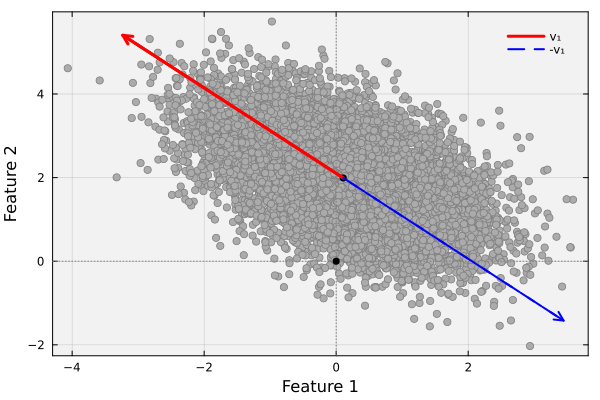

In [16]:
let

    # initialize -
    zscore = 3.91; # z-score for 99.99% confidence interval

    scatter(X[:,1], X[:,2], label="", c=:gray67,msc=:gray50) # plot the data points

    # plot coordinate axes through the origin
    vline!([0.0], color=:gray, lw=1, ls=:dot, label="")
    hline!([0.0], color=:gray, lw=1, ls=:dot, label="")
    scatter!([0], [0], color=:black, ms=4, label="")

    # overlay the leading eigenvector as an arrow (sign is arbitrary)
    μ = vec(mean(X, dims=1))
    scatter!([μ[1]], [μ[2]], color=:black, ms=4, label="")
    scale = zscore * sqrt(λ₁)
    x0, y0 = μ

    # +v₁ direction
    x1 = x0 + scale * v₁[1]
    y1 = y0 + scale * v₁[2]
    plot!([x0, x1], [y0, y1], arrow=:arrow, lw=3, color=:red, label="v₁")

    # -v₁ direction (same eigenspace)
    x2 = x0 - scale * v₁[1]
    y2 = y0 - scale * v₁[2]
    plot!([x0, x2], [y0, y2], arrow=:arrow, lw=2, color=:blue, ls=:dash, label="-v₁")
    

    # background, and labels
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    xlabel!("Feature 1", fontsize=18)
    ylabel!("Feature 2", fontsize=18)
end


__Why do we include the negative direction?__
When we estimate the eigenvector $\mathbf{v}_1$, both $\mathbf{v}_1$ and $-\mathbf{v}_1$ are valid eigenvectors corresponding to the same eigenvalue $\lambda_1$. This is because eigenvectors are defined up to a sign; if $\mathbf{v}$ is an eigenvector, then so is $-\mathbf{v}$. 

Suppose $\mathbf{A}\mathbf{v} = \lambda \mathbf{v}$. Multiplying both sides by -1 gives $\mathbf{A}(-\mathbf{v}) = -\lambda \mathbf{v} = \lambda(-\mathbf{v})$, confirming that $-\mathbf{v}$ is also an eigenvector associated with the eigenvalue $\lambda$.

___

## Summary
We generated synthetic two-dimensional data, computed its empirical covariance matrix, and used power iteration to find the dominant eigenvalue and eigenvector.

> __Key Takeaways:__
> 
> * **Empirical covariance captures data spread:** The sample covariance matrix $\hat{\mathbf{\Sigma}}$ quantifies how variables vary together and is computed by centering data and normalizing by $n-1$
> * **Power iteration finds dominant directions:** The iterative method converges to the largest eigenvalue and its eigenvector without computing the full eigendecomposition
> * **Dominant eigenvectors indicate maximum variance:** The eigenvector corresponding to the largest eigenvalue points in the direction where the data exhibits the greatest spread


These techniques form the foundation for dimensionality reduction methods like Principal Component Analysis.
___